## 프로젝트 2 : 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?

### (1) 데이터 가져오기
- 터미널에서 ~/data/data/bike-sharing-demand 경로에 train.csv 데이터를 train 변수로 가져 옵니다.
- 여기에서 데이터를 상세히 확인할 수 있습니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

train = pd.read_csv('./data/bike-sharing-demand/train.csv')

### (2) datetime 컬럼을 datetime 자료형으로 변환하고 연, 월, 일, 시, 분, 초까지 6가지 컬럼 생성하기

In [3]:
# train['datetime'] = pd.to_datetime(train['datetime'])
# train['year'] = train['datetime'].dt.year
# train['month'] = train['datetime'].dt.month
# train['day'] = train['datetime'].dt.day
# train['hour'] = train['datetime'].dt.hour
# train['minute'] = train['datetime'].dt.minute
# train['second'] = train['datetime'].dt.second

In [4]:
# datetime 컬럼을 datetime 자료형으로 변환
train['datetime'] = pd.to_datetime(train['datetime'])

# 추출할 시간 관련 속성들
time_attrs = ['year', 'month', 'day', 'hour', 'minute', 'second']

# for 루프를 사용하여 각 속성을 추출하고 저장
for attr in time_attrs:
    train[attr] = getattr(train['datetime'].dt, attr)

### (3) year, month, day, hour, minute, second 데이터 개수 시각화하기
- sns.countplot 활용해서 시각화하기
- subplot을 활용해서 한 번에 6개의 그래프 함께 시각화하기

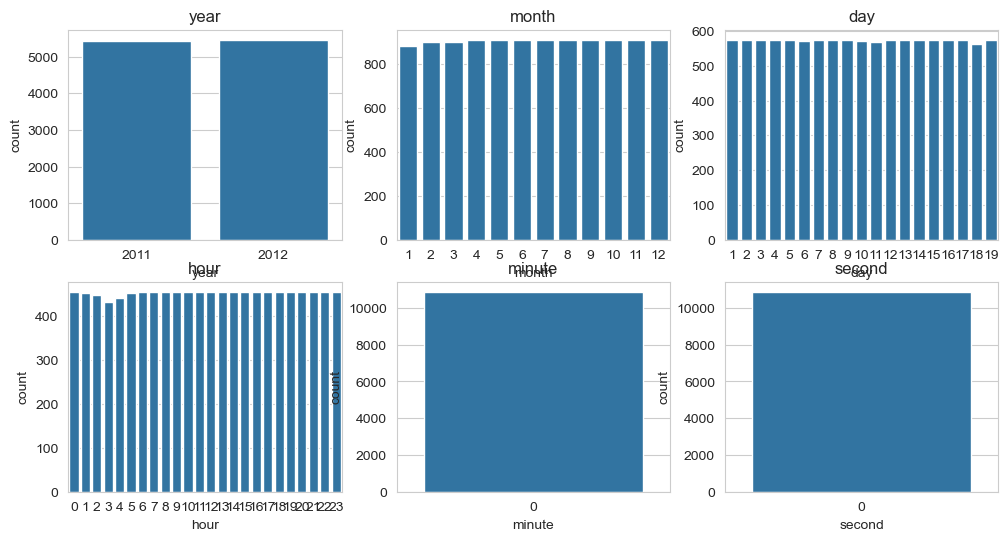

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2,3,i+1)
    sns.countplot(x=time_attrs[i], data=train)
    plt.title(time_attrs[i])

### (4) X, y 컬럼 선택 및 train/test 데이터 분리
- X(feature) 에는 어떤 데이터 컬럼을 넣어야 될지 고민해 봅시다 데이터 컬럼을 추가하거나 빼면서 잘 조합하여 데이터를 넣기 바랍니다. 만일 모든 데이터 컬럼(특징)을 넣는다면 오차 값이 말도 안 되게 적게 나올 수도 있습니다. 
ex) count를 예측하는데 casual,registered 컬럼이 필요할까요?

- count 값을 맞추고자 하므로, y 변수에 count 컬럼의 데이터 넣기

#### 데이터 필드 구성
- datetime : 기록 일시(1시간 간격)
- season : 계절(1봄, 2여름, 3가을, 4겨울)
- holiday : 공휴일 여부(0공휴일 아님, 1공휴일)
- workingday : 근무일 여부(0근무일 아님, 1근무일_주말과 공휴일이 아니면 근무일로 간주)
- weather : 날씨(1맑음, 2옅은 안개 및 약간 흐림, 3약간의 눈이나 비 천둥번개와 흐림, 4폭우와 천둥번개 및 눈 짙은 안개)
- temp : 실제 온도
- atemp : 체감 온도
- humidity : 상대 습도
- windspeed : 풍속
--------------------------
#### train 데이터에만 존재하는 feature
- casual : 등록되지 않은 사용자(비회원) 대여 수량
- registered : 등록된 사용자(회원) 대여 수량

#### 예측해야 할 타깃값
- count : 자전거 대여 수량 (회원 + 비회원)

In [6]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second'],
      dtype='object')

In [7]:
# 예측에 필요없는 변수 제거
train.drop(['datetime','minute','second','casual','registered'], axis=1, inplace=True)

In [8]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


#### 날씨 관련 수치형(연속형) 데이터 (temp, atemp, humidity, windspeed)
  - 이상치 파악

In [9]:
numerical = ['temp','atemp', 'humidity', 'windspeed']
train[numerical].describe()

,temp,atemp,humidity,windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395
std,7.79159,8.474601,19.245033,8.164537
min,0.82000,0.760000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500
50%,20.50000,24.240000,62.000000,12.998000
75%,26.24000,31.060000,77.000000,16.997900
max,41.00000,45.455000,100.000000,56.996900


- humidity와 windspeed의 데이터에서 최솟값으로 0이 있는데, 이것이 실제로 가능한 수치인지 생각해 볼 필요가 있다.
- 체감온도와 실제온도는 관련성이 높은 feature로 보이기에 두 데이터 간의 차이가 너무 크다면 이 또한 이상치로 보아야할 것이다.

#### 분포 파악

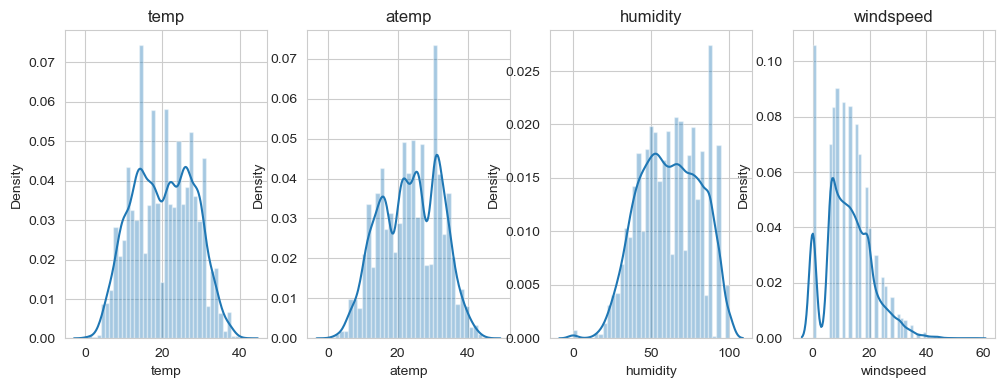

In [10]:
# 4개의 feature에 대한 distplot 그리기
plt.figure(figsize=(12, 4))
for i, feature in enumerate(numerical):
    plt.subplot(1, 4, i + 1)
    sns.distplot(train[feature], kde=True)
    plt.title(feature)

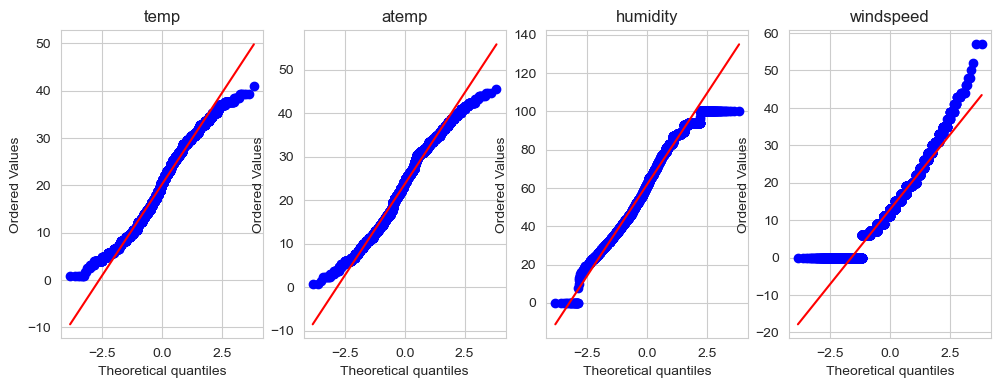

In [11]:
from scipy import stats

# 4개의 feature에 대한 qqplot 그리기
plt.figure(figsize=(12, 4))
for i, feature in enumerate(numerical):
    plt.subplot(1, 4, i + 1)
    stats.probplot(train[feature], dist="norm", plot=plt)
    plt.title(feature)

- 풍속(windspeed)의 경우 왼쪽으로 치우쳐져 있는 것을 볼 수 있다.
- 로그 변환을 고려해볼 필요가 있다.
- 풍속(windspeed)은 0이 될 수 없으므로 사실상 이상치라 볼 수 있고 이를 다른 값으로 대체해 주는 것이 바람직 해 보인다.

### 수치형 데이터의 상관관계 파악
- 온도와 체감온도에 대한 산점도

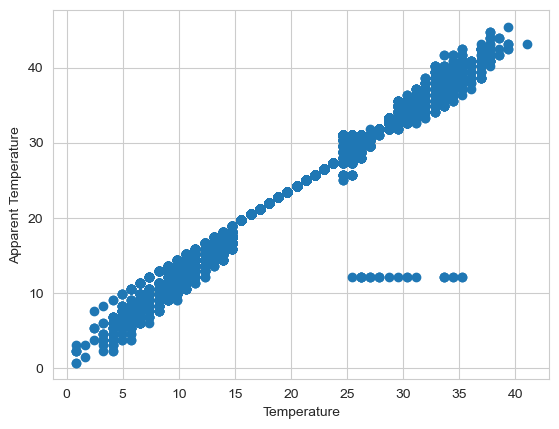

In [12]:
# 온도와 체감 온도에 대한 산점도 그리기
plt.scatter(train['temp'], train['atemp'])
plt.xlabel('Temperature')
plt.ylabel('Apparent Temperature')
plt.show()

- 온도와 체감온도가 상당히 차이가 많이 나는 데이터 확인 후 이상치 처리를 해볼 것이다.
- 유독 차이가 많이 나는 부분이 체감온도가 하나의 값인 것으로 보아 기록시 나타난 이상치로 보인다

### 이상치 처리
- 실제온도 / 체감온도의 비율로 이상치를 파악해보았다.
- 이 비율이 2를 넘어가면 이상치로 처리해주었다

In [13]:
train.loc[train['temp'] / train['atemp'] > 2,'atemp_out'] = 1
train.atemp_out.fillna(0, inplace=True)

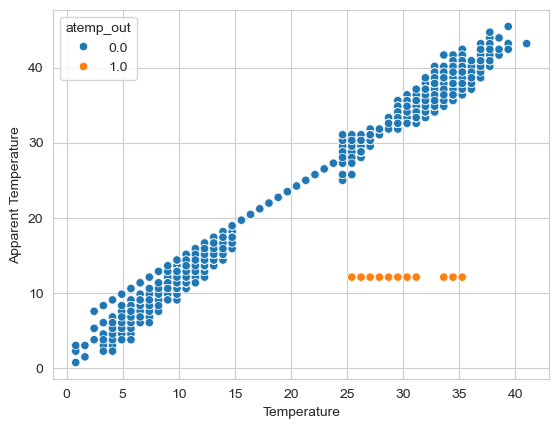

In [14]:
sns.scatterplot(data=train, x='temp', y='atemp', hue='atemp_out')
plt.xlabel('Temperature')
plt.ylabel('Apparent Temperature')
plt.show()

In [15]:
train[train.atemp_out == 1]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,atemp_out
8991,3,0,1,1,27.88,12.12,57,11.0014,88,2012,8,17,0,1.0
8992,3,0,1,1,27.06,12.12,65,7.0015,54,2012,8,17,1,1.0
8993,3,0,1,1,27.06,12.12,61,8.9981,19,2012,8,17,2,1.0
8994,3,0,1,1,26.24,12.12,65,7.0015,6,2012,8,17,3,1.0
8995,3,0,1,1,26.24,12.12,73,11.0014,9,2012,8,17,4,1.0
8996,3,0,1,1,26.24,12.12,73,7.0015,36,2012,8,17,5,1.0
8997,3,0,1,1,25.42,12.12,78,8.9981,157,2012,8,17,6,1.0
8998,3,0,1,1,26.24,12.12,73,7.0015,379,2012,8,17,7,1.0
8999,3,0,1,1,27.88,12.12,65,8.9981,668,2012,8,17,8,1.0
9000,3,0,1,1,28.70,12.12,58,7.0015,378,2012,8,17,9,1.0


- 데이터를 확인해보니 2012년 08월 17일의 체감온도가 12.12로 일정하게 잘 못 기록된 것으로 보인다.
- 랜덤 포레스트를 활용하여 이상치를 보간해 주었다.

In [16]:
from sklearn.ensemble import RandomForestRegressor
# atemp_out이 1인 데이터의 인덱스를 추출
index_outlier = train[train['atemp_out'] == 1].index

# atemp_out이 0인 데이터를 학습 데이터로 사용
X_train = train[train['atemp_out'] == 0][['temp', 'humidity', 'windspeed','month','hour']]
y_train = train[train['atemp_out'] == 0]['atemp']

# 랜덤 포레스트 모델 생성
model = RandomForestRegressor()

# 모델 학습
model.fit(X_train, y_train)

# atemp_out이 1인 데이터의 온도, 습도, 풍속을 사용하여 체감온도 예측
y_pred = model.predict(train[train['atemp_out'] == 1][['temp', 'humidity', 'windspeed','month','hour']])

# 예측한 체감온도를 train 데이터에 업데이트
train.loc[index_outlier, 'atemp'] = y_pred

In [17]:
y_pred

array([31.82   , 31.06   , 31.06   , 30.305  , 30.305  , 30.305  ,
       29.545  , 30.305  , 31.82   , 32.575  , 34.09   , 34.85   ,
       37.1428 , 36.9992 , 37.88   , 37.09735, 36.29655, 36.39515,
       36.3952 , 34.09   , 33.335  , 31.82   , 30.305  , 28.79   ])

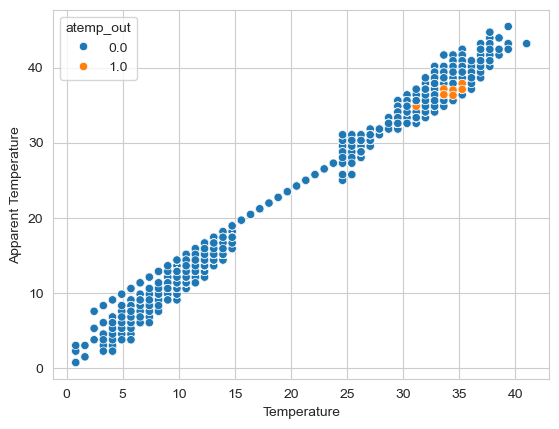

In [18]:
sns.scatterplot(data=train, x='temp', y='atemp', hue='atemp_out')
plt.xlabel('Temperature')
plt.ylabel('Apparent Temperature')
plt.show()

In [19]:
# atemp_out 열을 삭제
train.drop('atemp_out', axis=1, inplace=True)

### 다른 변수 간의 산점도
- 습도와 체감온도, 체감온도와 풍속, 습도와 풍속 등 일반적으로 관계가 있을 것이라 알려진 데이터 들의 관계를 파악해보고자 scatterplot을 확인해보았다
- 크게 관계는 없어보이나 풍속이 0인 경우가 있는데 이는 실제로 가능한 수치가 아니므로 확인해보아야할 것 같다

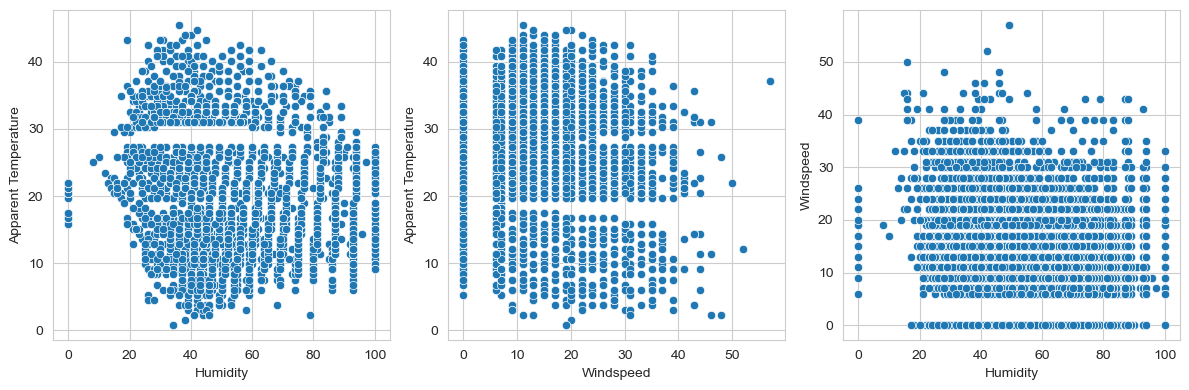

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.scatterplot(data=train, x='humidity', y='atemp')
plt.xlabel('Humidity')
plt.ylabel('Apparent Temperature')

plt.subplot(1, 3, 2)
sns.scatterplot(data=train, x='windspeed', y='atemp')
plt.xlabel('Windspeed')
plt.ylabel('Apparent Temperature')

plt.subplot(1, 3, 3)
sns.scatterplot(data=train, x='humidity', y='windspeed')
plt.xlabel('Humidity')
plt.ylabel('Windspeed')

plt.tight_layout()
plt.show()

### 풍속 0인 데이터 처리

In [21]:
train[train.windspeed == 0]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10826,4,0,1,2,16.40,20.455,87,0.0,232,2012,12,17,12
10829,4,0,1,2,17.22,21.210,88,0.0,211,2012,12,17,15
10846,4,0,1,1,15.58,19.695,94,0.0,662,2012,12,18,8
10860,4,0,1,1,13.94,16.665,49,0.0,132,2012,12,18,22


- 풍속이 0인 데이터는 1313개로 상당히 많아서 제거하기에는 너무 큰 숫자로 보인다
- 좀 더 자세한 분석을 통해 처리 방법을 고려해보자

<Axes: xlabel='windspeed', ylabel='count'>

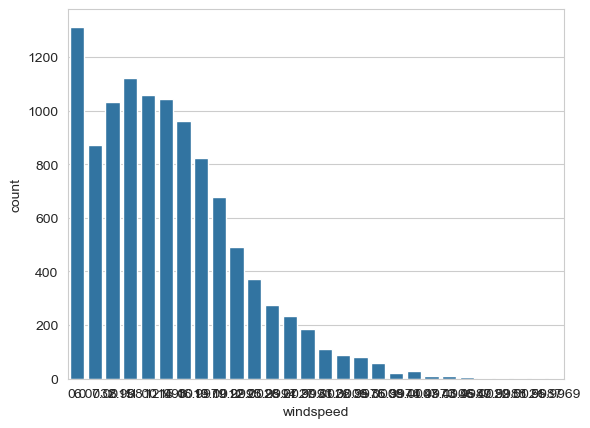

In [22]:
sns.countplot(x='windspeed', data=train)

In [23]:
train.windspeed.describe()

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64

In [24]:
train.windspeed.nunique()

28

In [25]:
train.windspeed.unique()

array([ 0.    ,  6.0032, 16.9979, 19.0012, 19.9995, 12.998 , 15.0013,
        8.9981, 11.0014, 22.0028, 30.0026, 23.9994, 27.9993, 26.0027,
        7.0015, 32.9975, 36.9974, 31.0009, 35.0008, 39.0007, 43.9989,
       40.9973, 51.9987, 46.0022, 50.0021, 43.0006, 56.9969, 47.9988])

In [26]:
train.windspeed.value_counts().sort_index()

windspeed
0.0000     1313
6.0032      872
7.0015     1034
8.9981     1120
11.0014    1057
12.9980    1042
15.0013     961
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
36.9974      22
39.0007      27
40.9973      11
43.0006      12
43.9989       8
46.0022       3
47.9988       2
50.0021       1
51.9987       1
56.9969       2
Name: count, dtype: int64

- 풍속 데이터를 확인해보니 linear 한 형태가 아니라 ordinal한 형태를 띄고 있음을 볼 수 있었다.

## 범주형 데이터 분석
- season 데이터는 범주형 데이터이지만 날씨의 특성상 여름, 봄, 가을, 겨울 순으로 온도가 낮아지기에 이를 순서형으로도 볼 수 있다. 데이터 분석을 통해 단순 명목형으로 볼 것인지 혹은 순서형으로 변환해 볼지 고민해 볼 계정이다.
- weather 데이터는 1은 맑은 날씨고 4로 갈수록 자전거 타기 어려운 날씨로 보여진다.
  - 따라서 순서형 데이터로 생각하고 데이터를 분석할 예정이다.
- 시각화 시 의미가 잘 드러나도록 문자열로 바꾸고 진행한다.

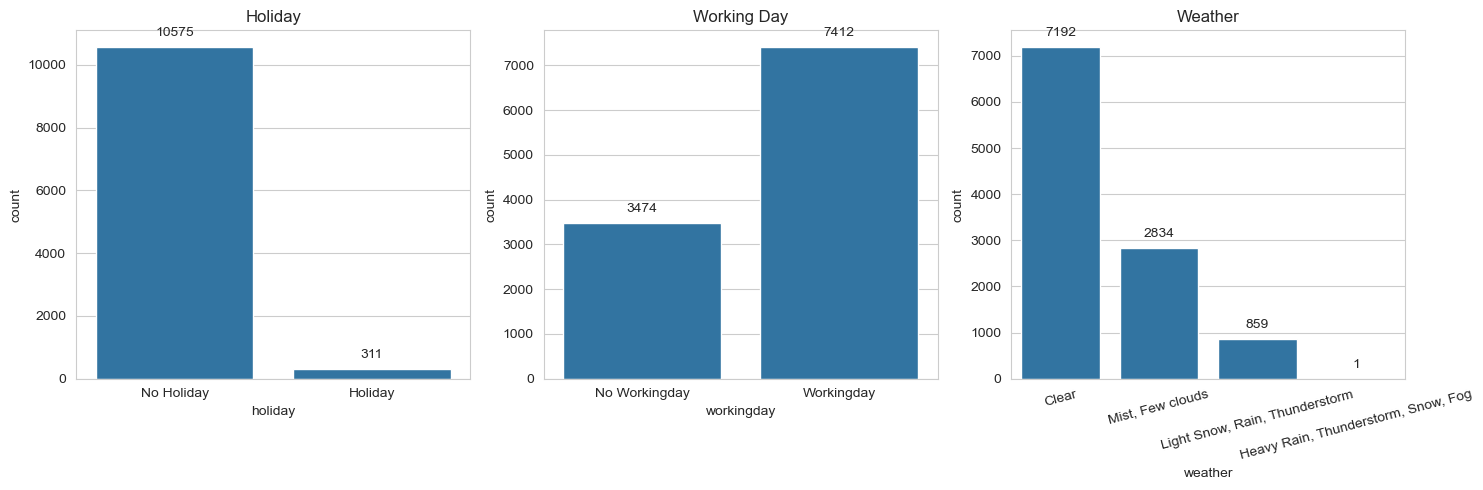

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# holiday
sns.countplot(x='holiday', data=train, ax=axes[0])
axes[0].set_title('Holiday')
axes[0].set_xticklabels(['No Holiday', 'Holiday'])
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# workingday
sns.countplot(x='workingday', data=train, ax=axes[1])
axes[1].set_title('Working Day')
axes[1].set_xticklabels(['No Workingday', 'Workingday'])
for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# weather
sns.countplot(x='weather', data=train, ax=axes[2])
axes[2].set_title('Weather')
axes[2].set_xticklabels(['Clear', 'Mist, Few clouds', 'Light Snow, Rain, Thunderstorm', 'Heavy Rain, Thunderstorm, Snow, Fog'])
axes[2].set_xticklabels(['Clear', 'Mist, Few clouds', 'Light Snow, Rain, Thunderstorm', 'Heavy Rain, Thunderstorm, Snow, Fog'], rotation=15)
for p in axes[2].patches:
    axes[2].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()


((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([  1,   1,   1, ..., 968, 970, 977])),
 (169.82942673231386, 191.5741319125482, 0.9372682766213162))

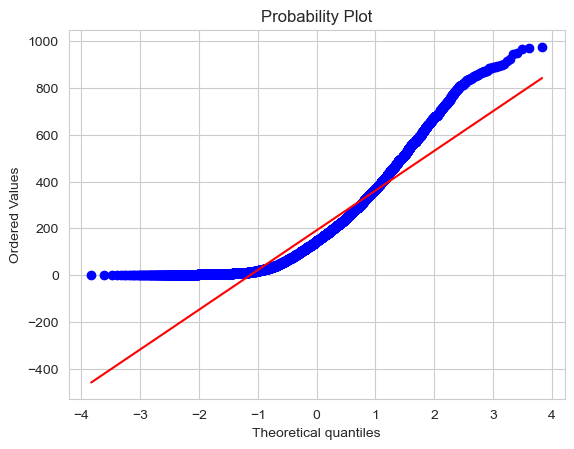

In [28]:
stats.probplot(train['count'], dist="norm", plot=plt)

- 분포가 왼쪽으로 많이 편향되어있는 것을 볼 수 있음.
- 회귀 모델이 좋은 성능을 내려면 데이터가 정규분포를 따라야 함
- 현재 타깃값인 count는 정규분포를 따르지 않아 현재 타깃값을 그대로 사용해 모델링하면 좋은 성능 기대 어려움
- 이에 따라 데이터 분포를 정규분포에 가깝게 만들기 위해 로그변환을 하고자 한다

In [29]:
import numpy as np

In [30]:
stats.probplot(np.log1p(train['count']), dist="norm")

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.87626461, 6.87832647,
         6.88550967])),
 (1.3647396459244165, 4.591363690454027, 0.961179378012696))

###  타겟값과 범주형 변수 간의 관계

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

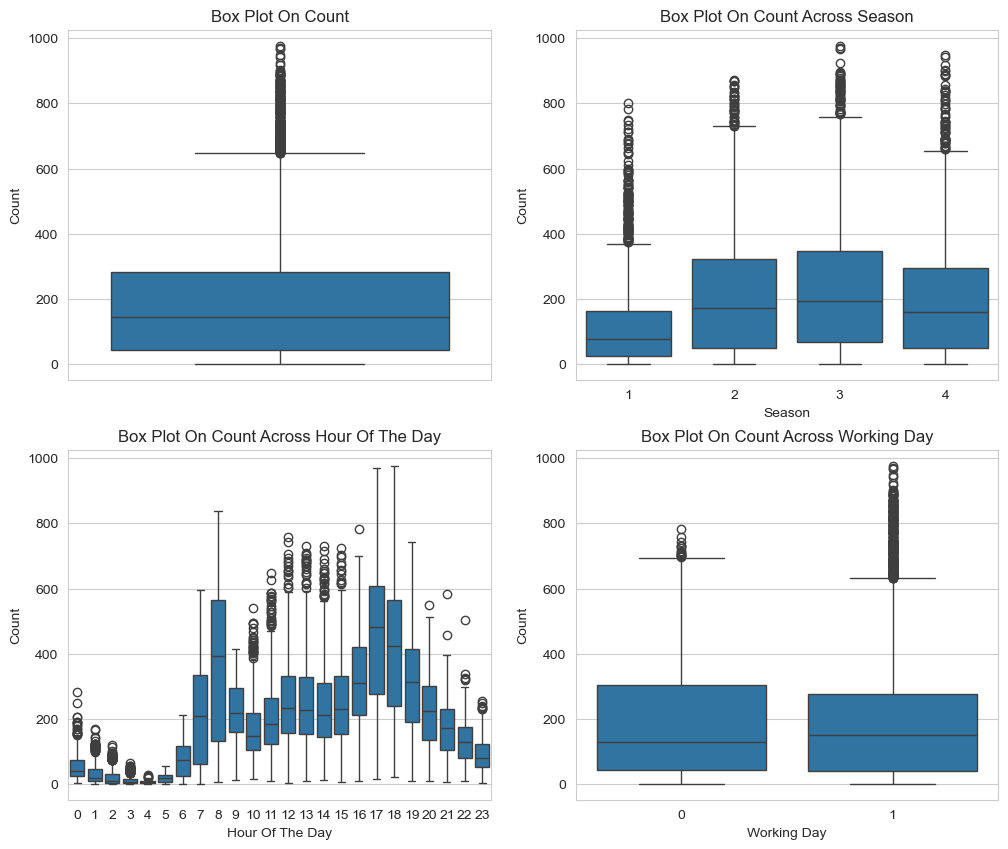

In [31]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train, y="count", orient="v",ax=axes[0][0])
sns.boxplot(data=train, y="count", x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train, y="count", x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train, y="count", x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

- 계절(Season) : 대여량의 중앙값을 비교해보면, 계절의 따른 대여량 차이에는 봄이 다른 계절에 비해 대여량이 낮은 것으로 보인다.
- 시간대(Hour of the Day) : 대여량의 중앙값을 비교해보면, 아침 7-9시, 저녁 5-6시 시간대에 대여량이 다른 시간대에 비해 상당히 많음을 볼 수 있다. 이는 출퇴근 시간대에 자전거를 이용하여 대여량이 많은 것으로 유추할 수 있다.
- 이에 대한 증거로, 대부분의 이상치 값(대여량이 높은 데이터)들은 평일에 분포되어 있음을 볼 수 있다.

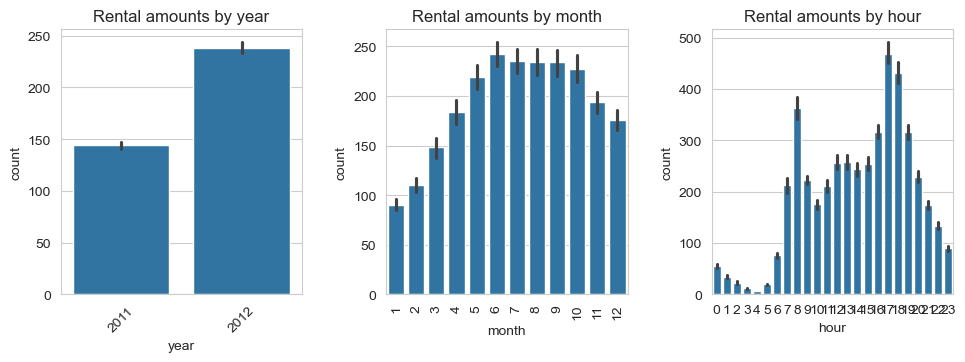

In [32]:
figure, axes = plt.subplots(nrows=1, ncols=3)
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(10, 3) # 전체 Figure 크기를 10x3인치로 설정

sns.barplot(x='year', y='count', data=train, ax=axes[0]) # ax 파라미터에는 AxesSubplot 객체를 전달
sns.barplot(x='month', y='count', data=train, ax=axes[1]) # 0행 0열의 축부터 2행 1열의 축까지 순서대로 전달
sns.barplot(x='hour', y='count', data=train, ax=axes[2])

axes[0].set(title='Rental amounts by year')
axes[1].set(title='Rental amounts by month')
axes[2].set(title='Rental amounts by hour')

axes[0].tick_params(axis='x', labelrotation=45)
axes[1].tick_params(axis='x', labelrotation=90)

Contingency Table:


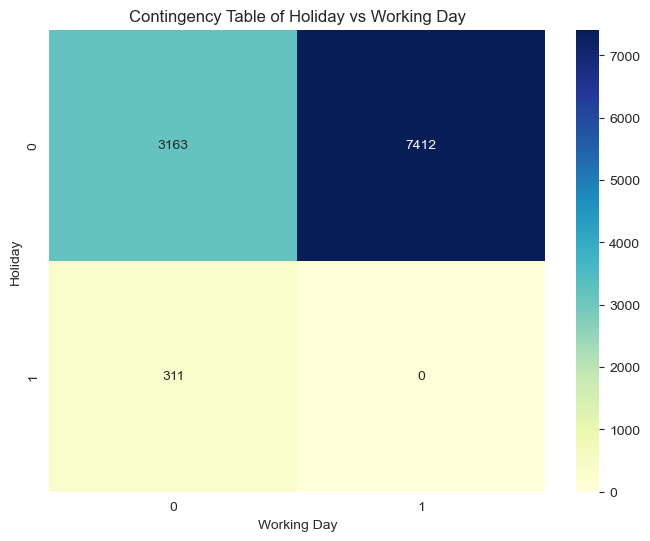

In [33]:
# Contingency Table 생성
contingency_table = pd.crosstab(train['holiday'], train['workingday'])

print("Contingency Table:")
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt='g')

plt.xlabel('Working Day')
plt.ylabel('Holiday')
plt.title('Contingency Table of Holiday vs Working Day')

plt.show()

In [34]:
# 0 : 휴일아닌 평일
# 1 : 휴일아닌 주말
# -1 : 휴일인 주말
train['day_off'] = train.holiday * (-1) + train.workingday + 1

In [35]:
train.day_off.value_counts()

day_off
2    7412
1    3163
0     311
Name: count, dtype: int64

In [36]:
train.drop(['holiday','workingday'], axis=1, inplace=True)

## weather 변수

<Axes: xlabel='weather', ylabel='count'>

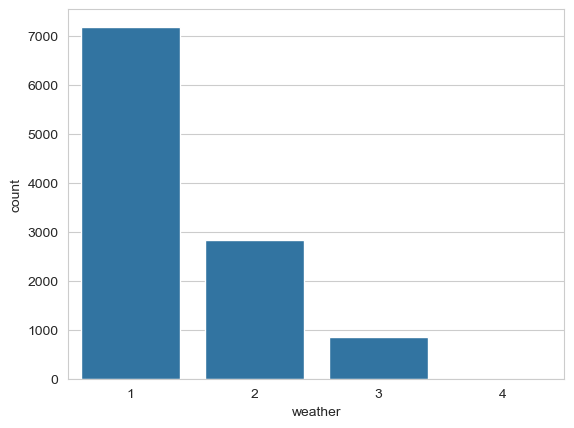

In [37]:
sns.countplot(x='weather', data = train)

In [38]:
train['weather'] = train['weather'].replace({4: 3})

In [39]:
# One-hot encoding for categorical variables
train = pd.get_dummies(train, columns=['season', 'day_off','year', 'month', 'day','hour']) # weather은 1,2,3이 순서가 있다고 생각해서 그대로사용

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
train['temperature'] = pca.fit_transform(train[['temp', 'atemp']])

In [41]:
train.drop(['temp','atemp'], axis=1, inplace=True)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.drop('count', axis=1), train['count'], test_size=0.2, random_state=123)

print(f"학습 데이터: {X_train.shape} 레이블: {y_train.shape}")
print(f"테스트 데이터: {X_test.shape} 레이블: {y_test.shape}")

학습 데이터: (8708, 68) 레이블: (8708,)
테스트 데이터: (2178, 68) 레이블: (2178,)


In [43]:
X_train.columns

Index(['weather', 'humidity', 'windspeed', 'season_1', 'season_2', 'season_3',
       'season_4', 'day_off_0', 'day_off_1', 'day_off_2', 'year_2011',
       'year_2012', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'temperature'],
      dtype='object')

In [44]:
# scikit-learn 패키지의 MinMaxScaler 클래스를 불러옵니다.
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체를 생성합니다.
minmax_scaler = MinMaxScaler()

# fit_transform()을 사용해서 학습과 스케일링을 한 번에 적용합니다.
train_minmax = minmax_scaler.fit_transform(X_train)

# Min-Max 스케일링이 완료된 데이터를 데이터프레임 형태로 변환합니다.
train_minmax = pd.DataFrame(train_minmax, 
                            index=X_train.index, 
                            columns=X_train.columns)

In [45]:
train_minmax

,weather,humidity,windspeed,season_1,season_2,season_3,season_4,day_off_0,day_off_1,day_off_2,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,temperature
9395,0.0,0.61,0.122840,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.320302
8023,0.0,0.51,0.333373,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262029
1503,1.0,0.66,0.263195,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.601856
493,0.0,0.37,0.298225,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.796086
6317,0.5,0.56,0.386035,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.766957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9785,0.0,0.66,0.105325,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.582410
7763,0.0,0.39,0.228047,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.320302
5218,0.0,0.35,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.718338
1346,0.0,0.61,0.105325,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.689209


In [46]:
y_train = np.log1p(y_train)

In [47]:
from sklearn.linear_model import LinearRegression

# scikit-learn에서 제공하는 선형 회귀 모델
lr_model = LinearRegression()

# model을 x와 y 데이터셋을 이용하여 학습시킴
lr_model.fit(train_minmax, y_train)

LinearRegression()

### (6) 학습된 모델로 X_test에 대한 예측값 출력 및 손실함수값 계산
- 학습된 모델에 X_test를 입력해서 예측값 출력하기
- 모델이 예측한 값과 정답 target 간의 손실함수 값 계산하기
- mse 값과 함께 rmse 값도 계산하기

In [48]:
test_minmax = minmax_scaler.fit_transform(X_test)

# model이 test 데이터에 대해 예측한 값을 array로 반환
y_pred = lr_model.predict(test_minmax)
y_pred = np.expm1(y_pred)

In [49]:
# 모델이 예측한 값과 정답 target 같의 손실함수 값 계산하기
mse = ((y_pred - y_test) ** 2).mean()
rmse = np.sqrt(mse)

In [50]:
print(f'mse: {mse}')
print(f'rmse: {rmse}')

mse: 9283.943270974496
rmse: 96.35322138348306


### (7) x축은 temp 또는 humidity로, y축은 count로 예측 결과 시각화하기
- x축에 X 데이터 중 temp 데이터를, y축에는 count 데이터를 넣어서 시각화하기
- x축에 X 데이터 중 humidity 데이터를, y축에는 count 데이터를 넣어서 시각화하기

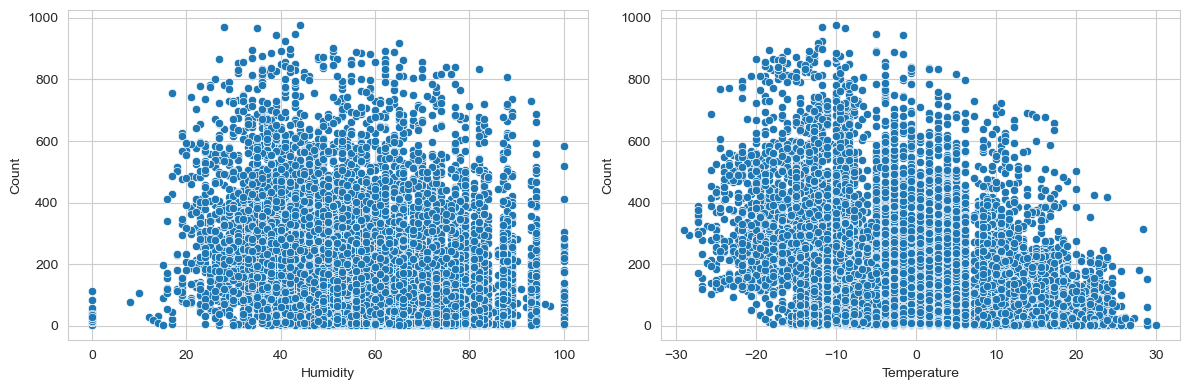

In [55]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(data=train, x='humidity', y='count')
plt.xlabel('Humidity')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.scatterplot(data=train, x='temperature', y='count')
plt.xlabel('Temperature')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### 피처들의 회귀 계수 값을 확인

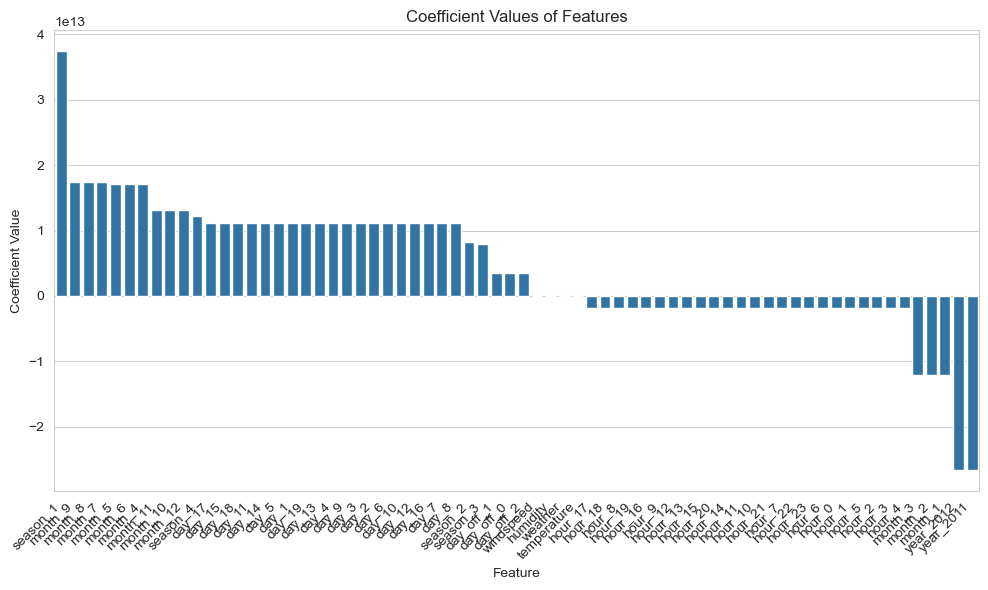

In [52]:
plt.figure(figsize=(10, 6))
coef = pd.Series(lr_model.coef_, index=X_train.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(y=coef_sort.values, x=coef_sort.index)
plt.xticks(rotation=45, ha='right') # 글씨가 잘 보이도록 조정
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Values of Features')

plt.tight_layout()